This notebook aims to compare IRRs at three regions with different lightning settings of WRF-Chem.

Three regions are defined in s5p_wrfchem_\<yyyy\>.ipynb: Fresh lightning, Downwind of Fresh lightning, and Aged Lightning.

In [1]:
import xarray as xr
import pandas as pd
from glob import glob
import proplot as pplt

# Disable warnings
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
reaction_dict = {'NO_HO2_IRR': 'NO + HO$_2$ -> OH + NO$_2$', 
                 'NO_RO2_Oxidation': 'NO + R$_i$O$_2$ -> NO$_2$ + R$_i$O',
                 'O1D_CB4_H2O_IRR': 'O($^1D$) + H$_2$O -> OH',
                 'OH_O3_IRR': 'O$_3$ + OH ->  HO$_2$ + O$_2$',
                 'HO2_O3_IRR': 'O$_3$ + HO$_2$ -> OH + 2O$_2$',
                }

## Read data

In [3]:
def read_s5p(dirname, date):
    ds = xr.open_mfdataset(glob(f'{dirname}/tm5/S5P_TM5_L2__NO2____{date}*.nc'), group='S5P')
    ds_tm5 = xr.open_mfdataset(glob(f'{dirname}/tm5/S5P_TM5_L2__NO2____{date}*.nc'), group='TM5')
    ds_nolnox = xr.open_mfdataset(glob(f'{dirname}/nolnox/S5P_CHEM_L2__NO2____{date}*.nc'), group='CHEM')
    ds_500lnox = xr.open_mfdataset(glob(f'{dirname}/lnox_500/S5P_CHEM_L2__NO2____{date}*.nc'), group='CHEM')
    ds_700lnox = xr.open_mfdataset(glob(f'{dirname}/lnox_700/S5P_CHEM_L2__NO2____{date}*.nc'), group='CHEM')

    mask = ds['no2_scd_flag']==0
    mask.load()

    return ds.where(mask), ds_tm5.where(mask), ds_nolnox.where(mask),\
           ds_500lnox.where(mask), ds_700lnox.where(mask),\


def read_mask(dirname):
    mask_fresh = xr.open_dataset(f'{dirname}/mask_fresh.nc')['mask_fresh']
    mask_downwind = xr.open_dataset(f'{dirname}/mask_downwind.nc')['mask_downwind']
    mask_aged = xr.open_dataset(f'{dirname}/mask_aged.nc')['mask_aged']

    return mask_fresh, mask_downwind, mask_aged

def mask_data(mask, ds_tm5, ds_nolnox, ds_500lnox, ds_700lnox):
    pressure = ds_tm5['plevels'].where(mask, drop=True).mean(['y', 'x']).load()

    o3_nolnox = ds_nolnox['o3apriori'].where(mask, drop=True).mean(['y', 'x']).load()
    o3_500lnox = ds_500lnox['o3apriori'].where(mask, drop=True).mean(['y', 'x']).load()
    o3_700lnox = ds_700lnox['o3apriori'].where(mask, drop=True).mean(['y', 'x']).load()

    return pressure, o3_nolnox, o3_500lnox, o3_700lnox

In [4]:
s5p_dir = '../data/s5p_chem/'
ds_2019, ds_2019_tm5, ds_2019_nolnox, ds_2019_500lnox, ds_2019_700lnox = read_s5p(s5p_dir, '20190725')
ds_2020, ds_2020_tm5, ds_2020_nolnox, ds_2020_500lnox, ds_2020_700lnox = read_s5p(s5p_dir, '20200901')

print('Reading masks ...')
mask_fresh, mask_downwind, mask_aged = read_mask(s5p_dir)

print('Calculating mean O3 profile in masks ...')
pressure_fresh, o3_nolnox_fresh, o3_500lnox_fresh, o3_700lnox_fresh = \
   mask_data(mask_fresh, ds_2019_tm5, ds_2019_nolnox, ds_2019_500lnox, ds_2019_700lnox)

pressure_downwind, o3_nolnox_downwind, o3_500lnox_downwind, o3_700lnox_downwind = \
   mask_data(mask_downwind, ds_2019_tm5, ds_2019_nolnox, ds_2019_500lnox, ds_2019_700lnox)

pressure_aged, o3_nolnox_aged, o3_500lnox_aged, o3_700lnox_aged = \
   mask_data(mask_aged, ds_2020_tm5, ds_2020_nolnox, ds_2020_500lnox, ds_2020_700lnox)

Reading masks ...
Calculating mean O3 profile in masks ...


In [5]:
def read_irr(dirname):
    ds_fresh = xr.open_mfdataset(glob(f'{dirname}/irr_fresh*nc'))
    ds_downwind = xr.open_mfdataset(glob(f'{dirname}/irr_downwind*nc'))
    ds_aged = xr.open_mfdataset(glob(f'{dirname}/irr_aged*nc'))

    return ds_fresh, ds_downwind, ds_aged

In [6]:
irr_dir = '../data/wrfchem/irr/'
ds_fresh, ds_downwind, ds_aged = read_irr(irr_dir)

## Plot $\Delta$P(O3) profile and IRR timeseries

In [7]:
def plot_o3_profile(ax, pressure, o3_nolnox, o3_500lnox, o3_700lnox):
    l1 = ax.plot((o3_500lnox-o3_nolnox)*1e9, pressure, label='500 mol/flash - \n 0 mol/flash', c='blue7')
    l2 = ax.plot((o3_700lnox-o3_nolnox)*1e9, pressure, label='700 mol/flash - \n 0 mol/flash', c='red7')

    ax.format(xlim=(-3, 3), ylim=(1000, 100), ylabel='Pressure (hPa)', xlabel='$\Delta$O$_3$ (ppbv)')

    return [l1, l2]


In [8]:
def plot_mean_irr(ax, da_lnox, da_nolnox, pmax, pmin, reaction_dict):
    # colors = ['red6', 'orange6', 'green6', 'blue6', 'violet6']
    # for colorblind people
    colors = ['#e41a1c', '#984ea3', '#f781bf', '#ff7f00', '#377eb8']
    # calculate the mean IRR between pmax and pmin
    da_lnox = da_lnox.sel(layer=slice(pmax, pmin)).mean('layer')
    da_nolnox = da_nolnox.sel(layer=slice(pmax, pmin)).mean('layer')

    lines = plot_irr(ax, colors, da_nolnox, reaction_dict, linestyle='dotted')
    lines = plot_irr(ax, colors, da_lnox, reaction_dict)

    return lines

def plot_irr(ax, colors, da, reaction_dict, linestyle='-'):
    total_irr = da.sel(varname=list(reaction_dict.keys())[:2]).sum(dim='varname')
    - da.sel(varname=list(reaction_dict.keys())[2:]).sum(dim='varname')

    lines = []
    for i,key in enumerate(reaction_dict.keys()):
        # "step": https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/step_demo.html#sphx-glr-gallery-lines-bars-and-markers-step-demo-py
#         if i <= 1:
#             k = 1
#         else:
#             k = -1

        line = ax.step(da.Time,
                        da.sel(varname=key),#*k,
                        where='pre',
                        label=reaction_dict[key],
                       color=colors[i],
#                         color=cmap(i / (len(da.RXN)-1)),
                        linestyle=linestyle,
                        )
        lines.append(line)

    # plot the total IRR
    total_irr.attrs['units'] = 'molec. cm$^{-3}$ s$^{-1}$'
    total_line = ax.step(total_irr.Time,
                          total_irr,
                          where='pre',
                          label='Total IRR', color='gray8',
                          linestyle=linestyle)

    return lines+[total_line]


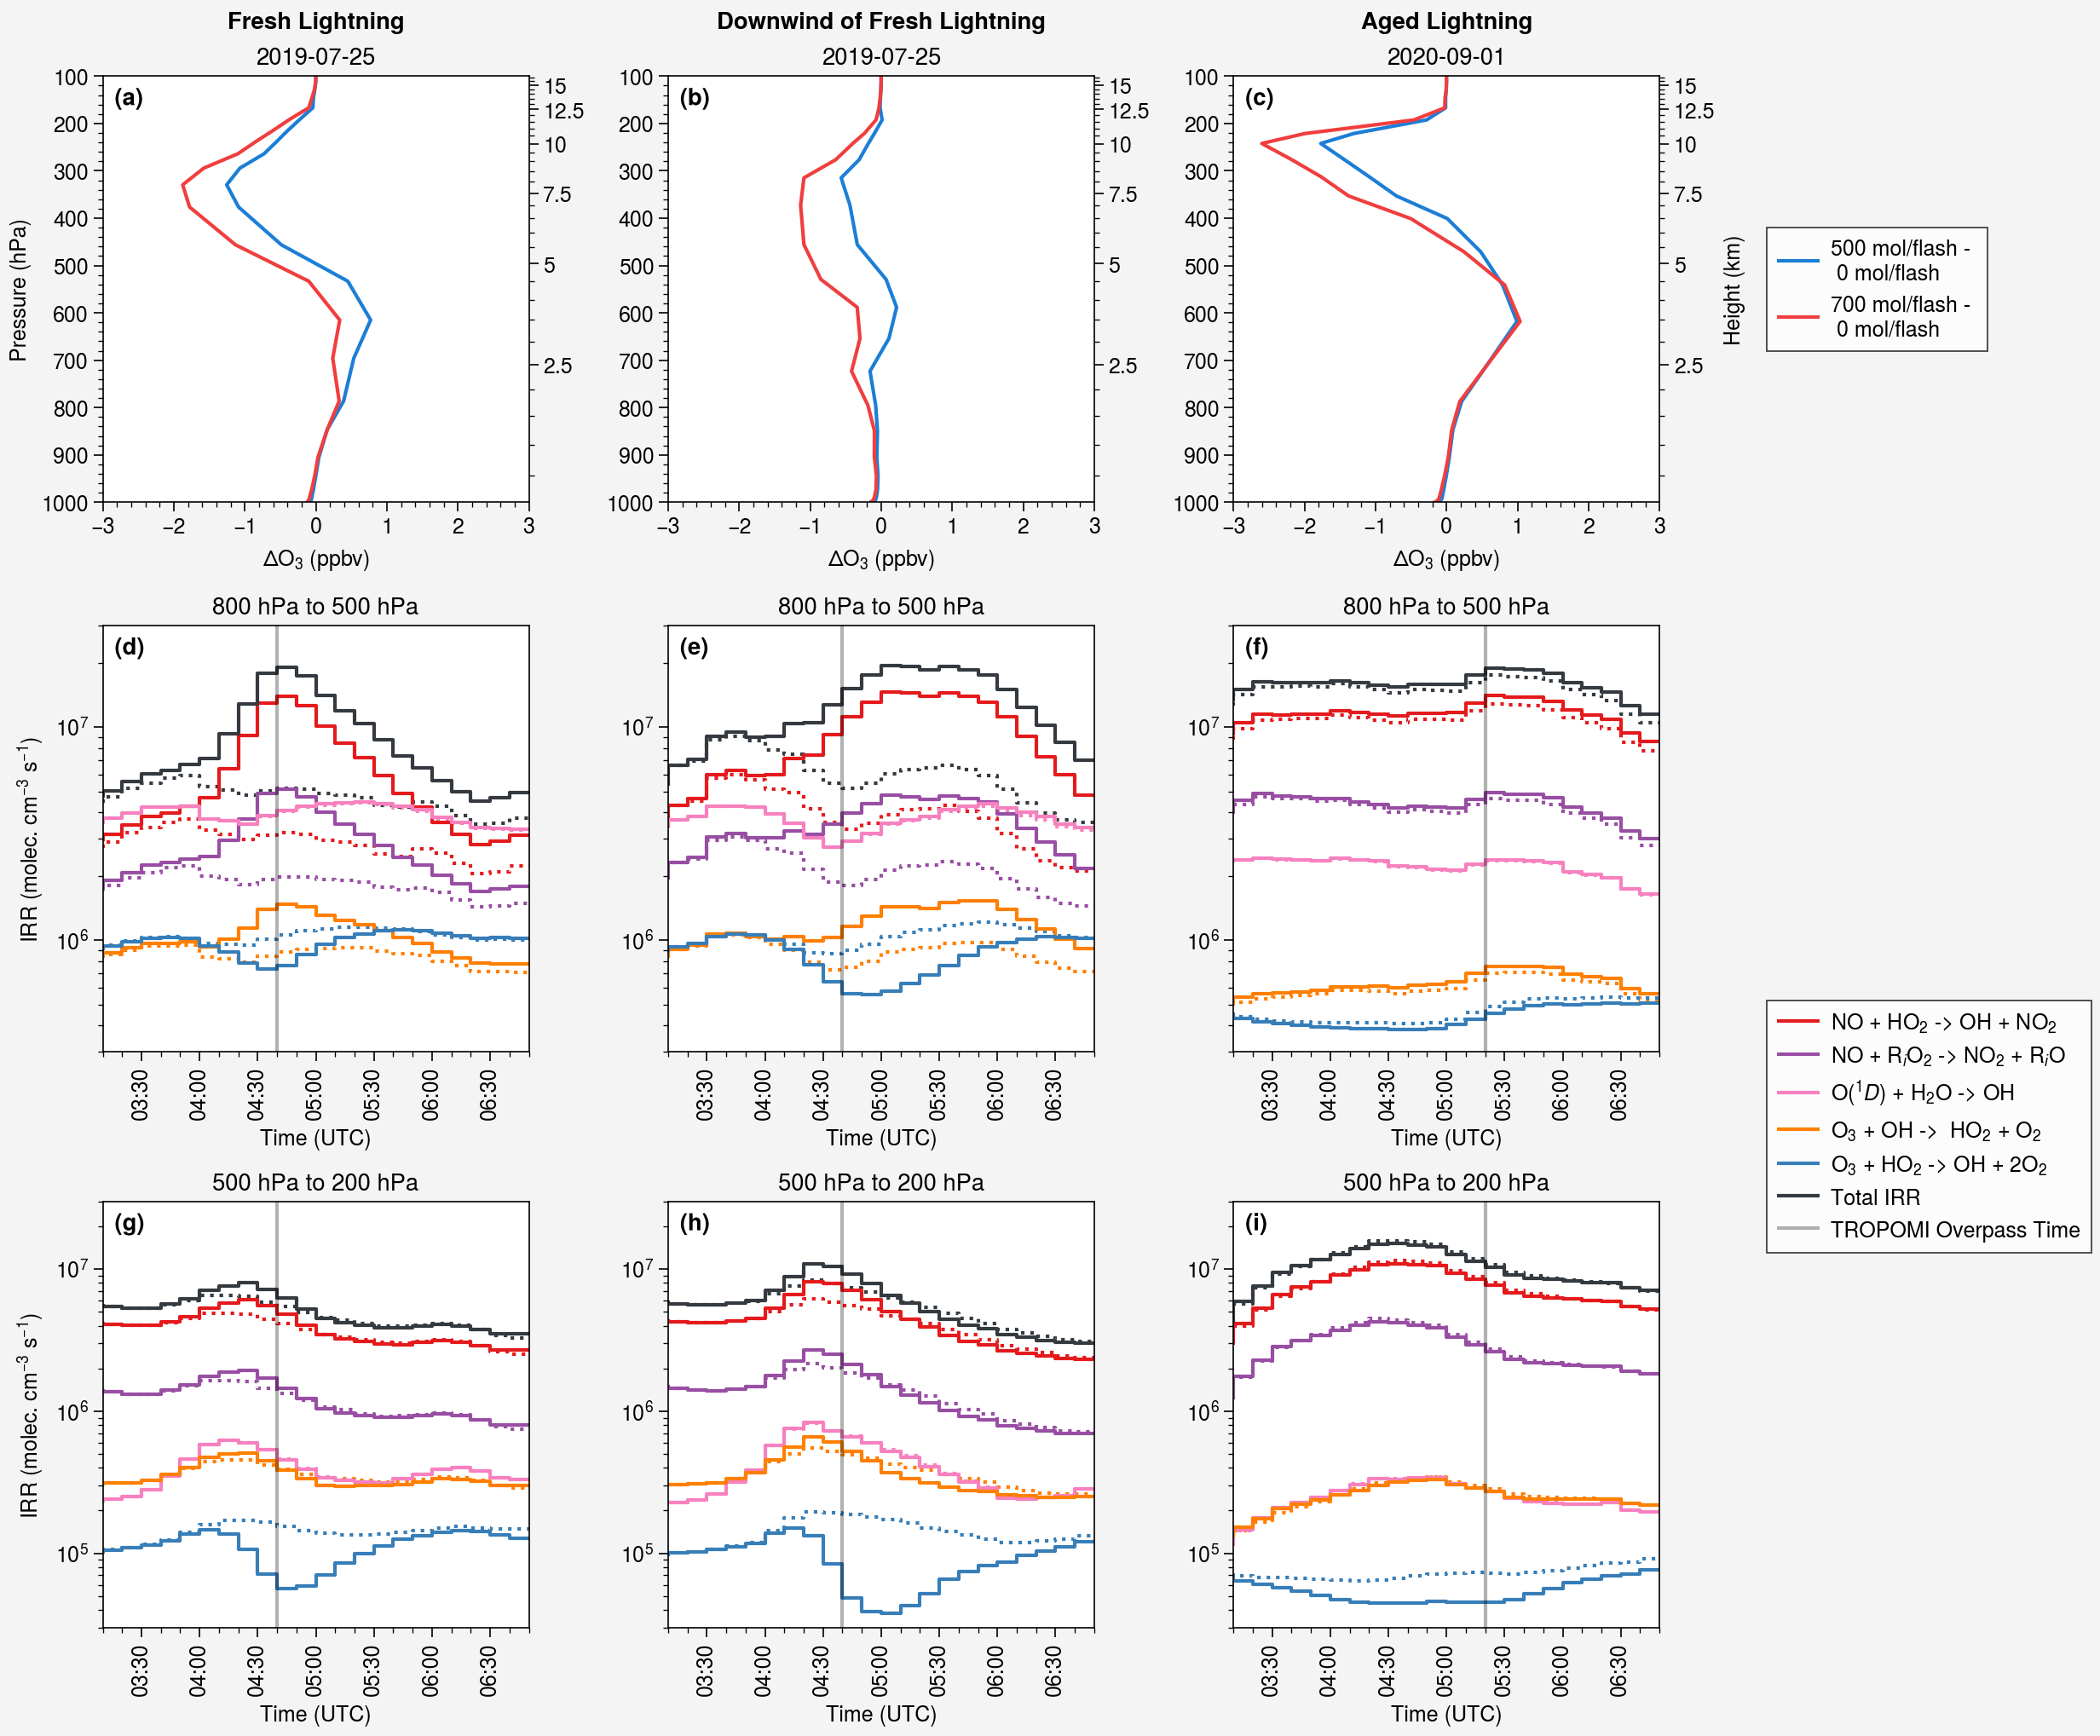

In [9]:
fig, axs = pplt.subplots(nrows=3, ncols=3, sharex=0, sharey=1, spany=0)

# ------ plot O3 profiles ------
ax = axs[0]
plot_o3_profile(ax, pressure_fresh, o3_nolnox_fresh, o3_500lnox_fresh, o3_700lnox_fresh)

ax = axs[1]
plot_o3_profile(ax, pressure_downwind, o3_nolnox_downwind, o3_500lnox_downwind, o3_700lnox_downwind)

ax = axs[2]
o3_lines = plot_o3_profile(ax, pressure_aged, o3_nolnox_aged, o3_500lnox_aged, o3_700lnox_aged)

fig.legend(o3_lines, ncol=1, row=1, loc='r')

# add height ticks
axs_dual = axs[:3].dualy('height', label='', ticks=2.5)
axs_dual[2].format(ylabel='Height (km)')

# ------ plot mean IRR between 800 hPa and 500 hPa ------
pmax = 800; pmin = 500
plot_mean_irr(axs[3], ds_fresh['irr_lnox'], ds_fresh['irr_nolnox'], pmax, pmin, reaction_dict)
plot_mean_irr(axs[4], ds_downwind['irr_lnox'], ds_downwind['irr_nolnox'], pmax, pmin, reaction_dict)
plot_mean_irr(axs[5], ds_aged['irr_lnox'], ds_aged['irr_nolnox'], pmax, pmin, reaction_dict)

# ------ plot mean IRR between 500 hPa and 200 hPa ------
pmax = 500; pmin = 200
plot_mean_irr(axs[6], ds_fresh['irr_lnox'], ds_fresh['irr_nolnox'], pmax, pmin, reaction_dict)
plot_mean_irr(axs[7], ds_downwind['irr_lnox'], ds_downwind['irr_nolnox'], pmax, pmin, reaction_dict)
legend = plot_mean_irr(axs[8], ds_aged['irr_lnox'], ds_aged['irr_nolnox'], pmax, pmin, reaction_dict)

# set axis
axs[:2].format(title='2019-07-25')
axs[2].format(title='2020-09-01')
axs[3:6].format(xlim=(ds_fresh.Time.values[0], ds_fresh.Time.values[-1]),
                ylim=(3e5, 3e7),
                title='800 hPa to 500 hPa')
axs[6:9].format(xlim=(ds_fresh.Time.values[0], ds_fresh.Time.values[-1]),
                ylim=(3e4, 3e7),
                title='500 hPa to 200 hPa')
axs[5].format(xlim=(ds_aged.Time.values[0], ds_aged.Time.values[-1]))
axs[8].format(xlim=(ds_aged.Time.values[0], ds_aged.Time.values[-1]))

axs[3:].format(yscale='log', yformatter='log',
               xlabel='Time (UTC)',
               ylabel='IRR (molec. cm$^{-3}$ s$^{-1}$)',
               xlocator=('minute', range(0, 60, 30)),
               xminorlocator=('minute', range(0, 60, 10)),
               xformatter='%H:%M')

axs.format(grid=False, abc=True, abcloc='ul', abcstyle='(a)',
           toplabels=('Fresh Lightning', 'Downwind of Fresh Lightning', 'Aged Lightning'),
           )

# add timeline
# -- TROPOMI relative overpass time
axs[3:5].axvline(pd.to_datetime('2019-07-25T04:40:00'), c='k', ls='-', alpha=0.3)
axs[5].axvline(pd.to_datetime('2020-09-01T05:20:00'), c='k', ls='-', alpha=0.3)
axs[6:8].axvline(pd.to_datetime('2019-07-25T04:40:00'), c='k', ls='-', alpha=0.3)
vline = axs[8].axvline(pd.to_datetime('2020-09-01T05:20:00'), c='k', ls='-', alpha=0.3, label='TROPOMI Overpass Time')

# add legend
fig.legend(legend+[vline], loc='r', ncols=1, rows=(2,3))

fig.savefig('../figures/irr_timeseries.pdf')

In [10]:
test = (ds_downwind['irr_lnox']-ds_downwind['irr_nolnox']).sel(layer=slice(500, 200)).mean('layer')
test_production = test.sel(varname=['NO_HO2_IRR', 'NO_RO2_Oxidation']).sum('varname')
test_loss = test.sel(varname=['O1D_CB4_H2O_IRR', 'OH_O3_IRR', 'HO2_O3_IRR']).sum('varname')
(test_production - test_loss).values.max()

2597042.2

- P(O3) increase with LNOx in 800 ~ 500 hPa, but decrease in 500 ~ 200 hPa
- NO+HO2 --> more O3+OH, less O3+HO2
- The increase of total IRR between 500 and 200 hPa can reach ?? , but the net O3 production decreased.
This coincides with Table 1 which indicates the dominant role of dynamic during convection.